In [1]:
'''3_24 加载波士顿房价数据
2019_12_6
'''
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
test_data

array([[1.80846e+01, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        2.72500e+01, 2.90500e+01],
       [1.23290e-01, 0.00000e+00, 1.00100e+01, ..., 1.78000e+01,
        3.94950e+02, 1.62100e+01],
       [5.49700e-02, 0.00000e+00, 5.19000e+00, ..., 2.02000e+01,
        3.96900e+02, 9.74000e+00],
       ...,
       [1.83377e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        3.89610e+02, 1.92000e+00],
       [3.58090e-01, 0.00000e+00, 6.20000e+00, ..., 1.74000e+01,
        3.91700e+02, 9.71000e+00],
       [2.92400e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        2.40160e+02, 9.81000e+00]])

In [5]:
train_targets.shape

(404,)

In [6]:
'''3_25 数据标准化
2019_12_6
'''
#mean是平均值
mean = train_data.mean(axis=0)
train_data -= mean
#std是标准差
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [7]:
'''3_26 模型定义
2019_12_6
'''
from keras import models
from keras import layers

#因为需要将同一个模型多次实例化所以用一个函数来构建模型
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu',))
    #网络的最后一层，没有激活，是一个线性层，这是标量回归的典型设置
    #添加输出函数会限制输出范围，最后一层是纯线性的，所以网络可以学会预测任意范围内的值
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',
                  #这里使用的是mse损失函数(均方误差, mean squared error)，它是预测值与目标值之差的平方
                  loss='mse',
                  #mae:平均绝对误差，它是预测值与目标值之差的绝对值
                  metrics=['mae'])
    return model

In [8]:
'''3_27 K折验证
2019_12_6
'''

import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    #准备验证数据:第k个分区的数据
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    #准备训练数据:其他所有分区的数据
    #concatenate()参数axis=0 就是对0轴的数组对象进行纵向的拼接
    #axis=1就是横向的拼接
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    #构建Keras模型(已编译)
    model = build_model()
    #训练模型(静默模式,verbose=0)
    model.fit(partial_train_data,
              partial_train_targets,
              epochs=num_epochs,
              batch_size=1,
              verbose=1)
    #在验证数据上评估模型
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    

processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
303/303 [==============================] - 1s 2ms/step - loss: 202.3819 - mean_absolute_error: 10.7722
Epoch 2/100
303/303 [==============================] - 0s 1ms/step - loss: 30.2364 - mean_absolute_error: 3.8336
Epoch 3/100
303/303 [==============================] - 0s 901us/step - loss: 21.3067 - mean_absolute_error: 3.1750
Epoch 4/100
303/303 [==============================] - 0s 1ms/step - loss: 18.2564 - mean_absolute_error: 2.8967
Epoch 5/100
303/303 [==============================] - 0s 1ms/step - loss: 16.6381 - mean_absolute_error: 2.6638
Epoch 6/100
303/303 [==============================] - 0s 1ms/step - loss: 15.4916 - mean_absolute_error: 2.5700
Epoch 7/100
303/303 [==============================] - 0s 960us/step - loss: 14.2239 - mean_absolute_error: 2.5324
Epoch 8/100
303/303 [==============================] - 0s 984us

303/303 [==============================] - 0s 877us/step - loss: 5.5640 - mean_absolute_error: 1.5047
Epoch 68/100
303/303 [==============================] - 0s 929us/step - loss: 5.3369 - mean_absolute_error: 1.4870
Epoch 69/100
303/303 [==============================] - 0s 1ms/step - loss: 5.6282 - mean_absolute_error: 1.4929
Epoch 70/100
303/303 [==============================] - 0s 980us/step - loss: 5.7686 - mean_absolute_error: 1.4724
Epoch 71/100
303/303 [==============================] - 0s 877us/step - loss: 5.5746 - mean_absolute_error: 1.5372
Epoch 72/100
303/303 [==============================] - 0s 929us/step - loss: 5.5639 - mean_absolute_error: 1.4844
Epoch 73/100
303/303 [==============================] - 0s 902us/step - loss: 5.3466 - mean_absolute_error: 1.4599
Epoch 74/100
303/303 [==============================] - 0s 1ms/step - loss: 5.1110 - mean_absolute_error: 1.4897
Epoch 75/100
303/303 [==============================] - 0s 877us/step - loss: 5.2741 - mean_absol

303/303 [==============================] - 0s 1ms/step - loss: 8.0674 - mean_absolute_error: 1.8059
Epoch 39/100
303/303 [==============================] - 0s 954us/step - loss: 7.1870 - mean_absolute_error: 1.7173
Epoch 40/100
303/303 [==============================] - 0s 1ms/step - loss: 7.4968 - mean_absolute_error: 1.8076
Epoch 41/100
303/303 [==============================] - 0s 1ms/step - loss: 7.5404 - mean_absolute_error: 1.7317
Epoch 42/100
303/303 [==============================] - 0s 941us/step - loss: 7.0799 - mean_absolute_error: 1.7103
Epoch 43/100
303/303 [==============================] - 0s 984us/step - loss: 7.1450 - mean_absolute_error: 1.7018
Epoch 44/100
303/303 [==============================] - 0s 1ms/step - loss: 7.1642 - mean_absolute_error: 1.7314
Epoch 45/100
303/303 [==============================] - 0s 974us/step - loss: 6.5000 - mean_absolute_error: 1.6514
Epoch 46/100
303/303 [==============================] - 0s 954us/step - loss: 7.0323 - mean_absolute_

303/303 [==============================] - 0s 951us/step - loss: 10.7859 - mean_absolute_error: 2.2393
Epoch 10/100
303/303 [==============================] - 0s 1ms/step - loss: 9.7635 - mean_absolute_error: 2.2228
Epoch 11/100
303/303 [==============================] - 0s 1ms/step - loss: 9.5543 - mean_absolute_error: 2.1557
Epoch 12/100
303/303 [==============================] - 0s 977us/step - loss: 8.9656 - mean_absolute_error: 2.1567
Epoch 13/100
303/303 [==============================] - 0s 1ms/step - loss: 8.7713 - mean_absolute_error: 2.0156
Epoch 14/100
303/303 [==============================] - 0s 1ms/step - loss: 8.4434 - mean_absolute_error: 2.0274
Epoch 15/100
303/303 [==============================] - 0s 993us/step - loss: 8.0327 - mean_absolute_error: 2.0795
Epoch 16/100
303/303 [==============================] - 0s 1ms/step - loss: 8.3585 - mean_absolute_error: 2.0111
Epoch 17/100
303/303 [==============================] - 0s 987us/step - loss: 7.9082 - mean_absolute_e

303/303 [==============================] - 0s 929us/step - loss: 3.9075 - mean_absolute_error: 1.3852
Epoch 81/100
303/303 [==============================] - 0s 999us/step - loss: 3.7925 - mean_absolute_error: 1.3818
Epoch 82/100
303/303 [==============================] - 0s 885us/step - loss: 3.7512 - mean_absolute_error: 1.3523
Epoch 83/100
303/303 [==============================] - 0s 877us/step - loss: 3.7582 - mean_absolute_error: 1.3842
Epoch 84/100
303/303 [==============================] - 0s 877us/step - loss: 3.7017 - mean_absolute_error: 1.3977
Epoch 85/100
303/303 [==============================] - 0s 1ms/step - loss: 3.6161 - mean_absolute_error: 1.3629
Epoch 86/100
303/303 [==============================] - 0s 1ms/step - loss: 3.5402 - mean_absolute_error: 1.3680
Epoch 87/100
303/303 [==============================] - 0s 911us/step - loss: 3.6364 - mean_absolute_error: 1.3237
Epoch 88/100
303/303 [==============================] - 0s 967us/step - loss: 3.2453 - mean_absol

303/303 [==============================] - 0s 984us/step - loss: 6.3491 - mean_absolute_error: 1.6147
Epoch 52/100
303/303 [==============================] - 0s 1ms/step - loss: 6.4152 - mean_absolute_error: 1.5815
Epoch 53/100
303/303 [==============================] - 0s 875us/step - loss: 5.8169 - mean_absolute_error: 1.5896
Epoch 54/100
303/303 [==============================] - 0s 861us/step - loss: 6.4931 - mean_absolute_error: 1.6286
Epoch 55/100
303/303 [==============================] - 0s 1ms/step - loss: 6.2684 - mean_absolute_error: 1.6096
Epoch 56/100
303/303 [==============================] - 0s 1ms/step - loss: 6.2855 - mean_absolute_error: 1.5530
Epoch 57/100
303/303 [==============================] - 0s 888us/step - loss: 5.9167 - mean_absolute_error: 1.5803
Epoch 58/100
303/303 [==============================] - 0s 970us/step - loss: 6.3694 - mean_absolute_error: 1.5811
Epoch 59/100
303/303 [==============================] - 0s 1ms/step - loss: 6.0063 - mean_absolute_

In [9]:
all_scores

[2.1258817639681373, 2.2007482335118964, 2.841000252430982, 2.295423225601121]

In [10]:
np.mean(all_scores)

2.365763368878034

In [20]:
'''3_28 保存每折的验证结果
2019_12_8
'''
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    #准备验证数据:第k个分区的数据
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    #准备训练数据:其他所有分区的数据
    #concatenate()参数axis=0 就是对0轴的数组对象进行纵向的拼接
    #axis=1就是横向的拼接
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    #构建Keras模型(已编译)
    model = build_model()
    #训练模型(静默模式,verbose=0)
    history = model.fit(partial_train_data,
                        partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs,
                        batch_size=1,
                        verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [21]:
'''3_29 计算所有轮次中的K折验证分数平均值
2019_12_8
'''
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

In [28]:
len(average_mae_history)

500

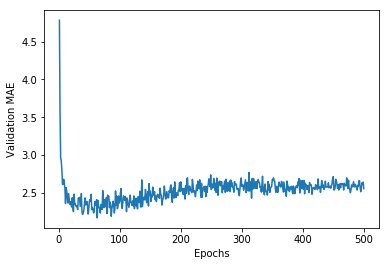

In [22]:
'''3_30 绘制验证分数
2019_12_8
'''
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

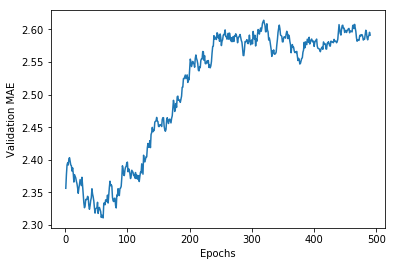

In [23]:
'''3_31 绘制验证分数(删除前10个数据点)
2019_12_8
'''
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [26]:
'''3_32 训练最终模型
2019_12_8
'''
model = build_model()
#一个全新编译好的模型
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=1)
test_mse_score, test_mae_socre = model.evaluate(test_data, test_targets)

Epoch 1/80
404/404 [==============================] - 1s 3ms/step - loss: 527.8589 - mean_absolute_error: 21.0867
Epoch 2/80
404/404 [==============================] - 0s 129us/step - loss: 378.9312 - mean_absolute_error: 17.3607
Epoch 3/80
404/404 [==============================] - 0s 119us/step - loss: 216.0193 - mean_absolute_error: 12.2941
Epoch 4/80
404/404 [==============================] - 0s 124us/step - loss: 98.5463 - mean_absolute_error: 7.6928
Epoch 5/80
404/404 [==============================] - 0s 124us/step - loss: 53.0625 - mean_absolute_error: 5.4323
Epoch 6/80
404/404 [==============================] - 0s 111us/step - loss: 36.6165 - mean_absolute_error: 4.3649
Epoch 7/80
404/404 [==============================] - 0s 106us/step - loss: 28.4892 - mean_absolute_error: 3.7575
Epoch 8/80
404/404 [==============================] - 0s 97us/step - loss: 24.1500 - mean_absolute_error: 3.4492
Epoch 9/80
404/404 [==============================] - 0s 104us/step - loss: 21.6283 -

404/404 [==============================] - 0s 89us/step - loss: 5.7959 - mean_absolute_error: 1.7110
Epoch 74/80
404/404 [==============================] - 0s 92us/step - loss: 5.8081 - mean_absolute_error: 1.6968
Epoch 75/80
404/404 [==============================] - 0s 89us/step - loss: 5.6006 - mean_absolute_error: 1.6487
Epoch 76/80
404/404 [==============================] - 0s 92us/step - loss: 5.6912 - mean_absolute_error: 1.7055
Epoch 77/80
404/404 [==============================] - 0s 82us/step - loss: 5.5925 - mean_absolute_error: 1.6860
Epoch 78/80
404/404 [==============================] - 0s 97us/step - loss: 5.6627 - mean_absolute_error: 1.6794
Epoch 79/80
404/404 [==============================] - 0s 87us/step - loss: 5.5908 - mean_absolute_error: 1.6638
Epoch 80/80
102/102 [==============================] - 0s 4ms/step


In [27]:
test_mae_socre

2.583680180942311